In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import datetime as dt 
# dt as time_series operation
%matplotlib inline
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# storage
from google.datalab import Context
import google.datalab.bigquery as bq
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# square scale
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)
'''
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 9)**2, label='$y=x^2$')
ax.legend()

ax.set_yscale('squareroot')
ax.set_yticks(np.arange(0,9,2)**2)
ax.set_yticks(np.arange(0,8.5,0.5)**2, minor=True)

plt.show()
''';

# IO

In [3]:
%gcs read --object gs://kk_data/ft_satisfaction.csv -v df_ft_satis

In [4]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))

In [5]:
%gcs read --object gs://kk_data/ft_day_listen.csv -v df_ft_day_listen

In [6]:
df_ft_day_listen = pd.read_csv(StringIO(df_ft_day_listen))
df_train = pd.merge(df_ft_day_listen, df_ft_satis, how='left',on=['msno'])

In [7]:
%gcs read --object gs://kk_data/sub_ft_satisfaction.csv -v df_sub_ft_satis

In [8]:
%gcs read --object gs://kk_data/sub_ft_day_listen.csv -v df_sub_ft_day_listen

In [9]:
df_sub_ft_day_listen = pd.read_csv(StringIO(df_sub_ft_day_listen))
df_sub_ft_satis = pd.read_csv(StringIO(df_sub_ft_satis))
df_sub = pd.merge(df_sub_ft_day_listen, df_sub_ft_satis, how='left',on=['msno'])

df_sub.is_churn = np.nan

In [10]:
%gcs read --object gs://kk_data/members_v3.csv -v members

In [11]:
df_members =pd.read_csv(StringIO(members))

In [12]:
df_data = df_train.append(df_sub)
df_data = pd.merge(df_data, df_members, how='left',on=['msno'])
gender_encode = {'male':1, 'female':2}
df_data.gender = df_data.gender.map(gender_encode)
# change feature name
df_data = df_data.rename(columns={'day_listen':'six_month_day_listen','user_latent_satisfaction':'six_month_satis'})
# missing value 
print('-'*10,'missing value summary','-'*10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_data.isnull().sum() / len(df_data))

---------- missing value summary ----------
msno                     0.000
is_churn                 0.506
six_month_day_listen     0.173
six_month_satis          0.173
city                     0.123
bd                       0.123
gender                   0.646
registered_via           0.123
registration_init_time   0.123
dtype: float64


In [13]:
df_data.head()

,msno,is_churn,six_month_day_listen,six_month_satis,city,bd,gender,registered_via,registration_init_time
0,0nB9bTDIfGnfO+0TI5mI26X9oNuy/T4fIzND+D+RcQ4=,0.000,nan,nan,nan,nan,nan,nan,nan
1,2G9f1kCzNUsrpHaOKlHzK11vmtC9HfXmvYmHqAlr1Yc=,0.000,nan,nan,1.000,0.000,nan,7.000,20150826.000
2,QKXNX8FDdZNpmo50ENWER9/xdbjUGwO3euVsYoaYVu8=,0.000,nan,nan,1.000,0.000,nan,7.000,20130825.000
3,QMa4IOS+j5ryiIyE2ywjxjaxUeKFpFNNr8MCMzpbIsc=,0.000,nan,nan,nan,nan,nan,nan,nan
4,RM0u90xU9bIn+1P3yHVW9fuF2RvPrsEoaRJazS3sSy8=,0.000,nan,nan,nan,nan,nan,nan,nan


# Member features

## Registered_via

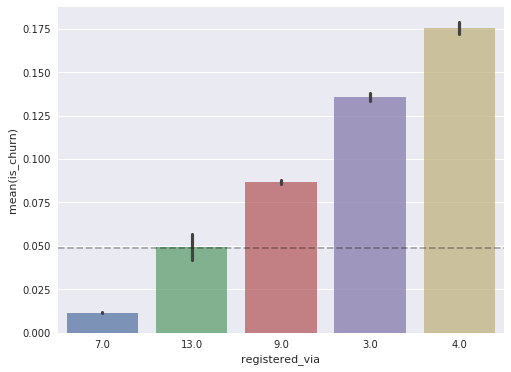

In [14]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

In [15]:
df_data.registered_via = df_data.registered_via.fillna(-1)
df_data.six_month_day_listen = df_data.six_month_day_listen.fillna(-1)
df_data.six_month_satis = df_data.six_month_satis.fillna(-1)

### Modeling

In [28]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [29]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [36]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
reg_via_fts = ['msno','is_churn','six_month_day_listen', 'six_month_satis','registered_via']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')


In [37]:
reg_via_model, reg_via_val_score,\
reg_via_pred = model_training_rf(df_train[reg_via_fts],df_sub[reg_via_fts])

In [38]:
reg_via_model_xgb, reg_via_val_score_xgb,\
reg_via_pred_xgb = model_training_xgb(df_train[reg_via_fts],df_sub[reg_via_fts])

[0]	validation_0-logloss:0.629554	validation_1-logloss:0.629492
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.165479	validation_1-logloss:0.164147
Stopping. Best iteration:
[96]	validation_0-logloss:0.16525	validation_1-logloss:0.164031



In [43]:
print('day_listen + user_letent_satisfaction logloss val: ',0.192158)
print('reg_via log_loss val xgb: ',np.around(reg_via_val_score_xgb,decimals=6))
print('reg_via log_loss val rf: ',np.around(reg_via_val_score,decimals=6))
print('-'*20,'LB','-'*20)
print('reg_via log_loss LB : ',0.13264)

day_listen + user_letent_satisfaction logloss val:  0.192158
reg_via log_loss val xgb:  0.164043
reg_via log_loss val rf:  0.167576
-------------------- LB --------------------
reg_via log_loss LB :  0.13264


In [41]:
reg_via_pred_xgb.to_csv("/content/datalab/sub_reg_via_xgb_pred.csv", index=False)

In [42]:
!gsutil cp '/content/datalab/sub_reg_via_xgb_pred.csv' 'gs://kk_data/submission/sub_reg_via_xgb_pred.csv';

Copying file:///content/datalab/sub_reg_via_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 49.1 MiB/ 49.1 MiB]                                                
Operation completed over 1 objects/49.1 MiB.                                     


In [68]:
'''fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(reg_via_model_xgb,importance_type='gain',ax=ax,xlabel='structure gain')
# importance --> index --> sort
indices = np.argsort(reg_via_model.feature_importances_)[::-1]
# plot
g = sns.barplot(y = df_train[reg_via_fts].drop(labels=['msno','is_churn'],axis=1).columns[indices], 
                x = reg_via_model.feature_importances_[indices],
               orient='h')
g.set_xlabel("Relative Importance", fontsize = 12)
# g.set_ylabel("Features", fontsize = 12)
# reg_via_model.feature_importances_''';

## Age

In [44]:
display(df_data[['bd']].describe())
# how many % of meanful values? 
meaningful = (df_data.bd > 0 ) & (df_data.bd < 90)
print('Ages between 0 ~ 90   :  %.3f   ' %( len(df_data[meaningful]) / len(df_data) ))

,bd
count,1572841.000
mean,12.073
std,18.998
min,-3152.000
25%,0.000
50%,0.000
75%,26.000
max,2016.000


Ages between 0 ~ 90   :  0.350   


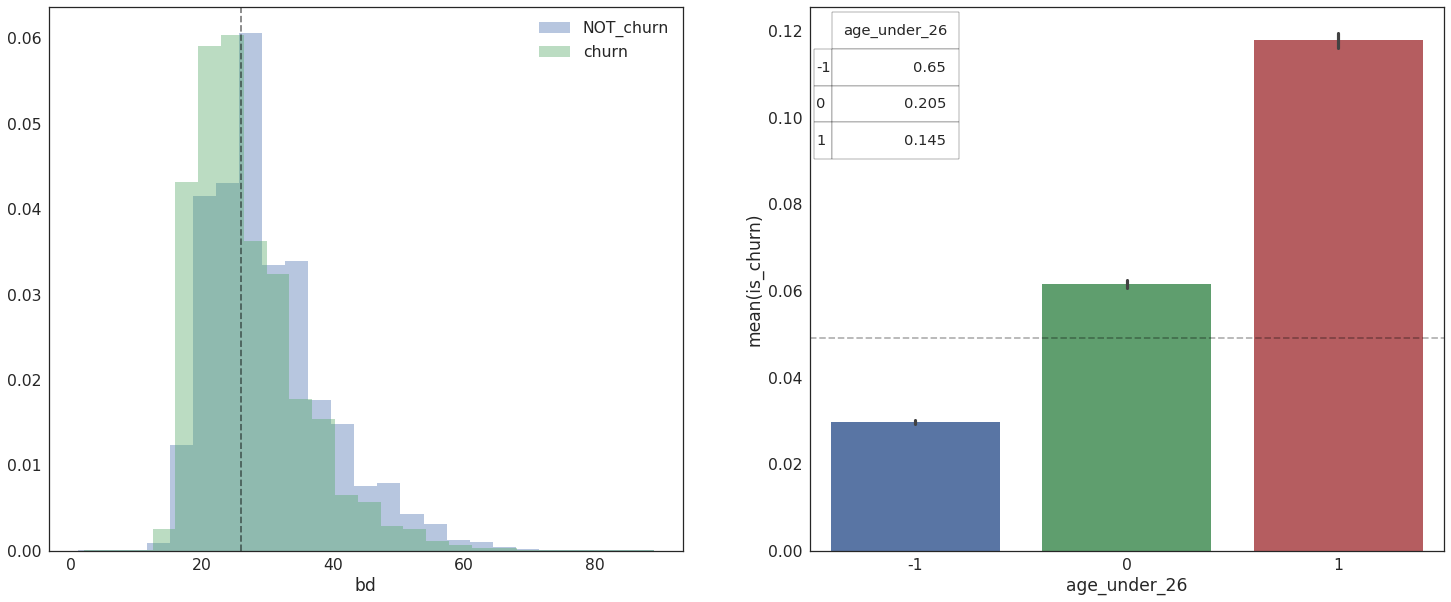

In [45]:
sns.set(font_scale=1.56)
from pandas.plotting import table

# create fig and ax 
with sns.axes_style('white'):

    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
# distribution
    NOT_churn = ( (df_data.is_churn == 0) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    churn = ( (df_data.is_churn == 1) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    bins= 25
    sns.distplot(df_data.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_data.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# feature engineering
# create feature  bd<26 == 1, bd>26 ==0 , other = -1
    condition = df_data.bd < 26
    df_data['age_under_26'] = df_data.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_data['age_under_26'].value_counts().sort_index() / len(df_data) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_data,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

### Modeling

In [46]:
# split and prepare features 
df_train = df_data[:len(df_train)]
df_sub = df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
age_fts = reg_via_fts + ['age_under_26']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')


In [48]:
print('training using features:' ,[fts for fts in age_fts if fts not in exclude_list])
age_model_xgb, age_val_score_xgb,\
age_pred_xgb = model_training_xgb(df_train[age_fts],df_sub[age_fts])

training using features: ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26']
[0]	validation_0-logloss:0.629484	validation_1-logloss:0.629412
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.163379	validation_1-logloss:0.161816
Stopping. Best iteration:
[118]	validation_0-logloss:0.162942	validation_1-logloss:0.161544



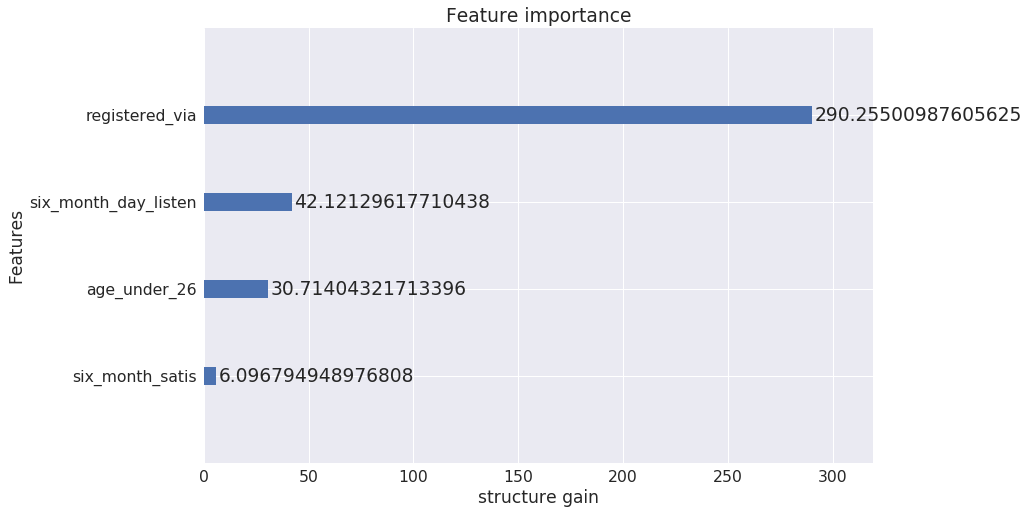

In [49]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(age_model_xgb,importance_type='gain',ax=ax,xlabel='structure gain')

In [51]:
age_pred_xgb.to_csv("/content/datalab/sub_age_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_age_xgb_pred.csv' 'gs://kk_data/submission/sub_age_xgb_pred.csv';

print('reg_via logloss val: ',0.164043)
print('reg_via logloss LB: ',0.13264)
print('-'*20,' + age','-'*20)
print('age log_loss LB : ',0.161515)
print('age log_loss LB : ',0.13161)

Copying file:///content/datalab/sub_age_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 49.0 MiB/ 49.0 MiB]                                                
Operation completed over 1 objects/49.0 MiB.                                     
reg_via logloss val:  0.164043
reg_via logloss LB:  0.13264
--------------------  + age --------------------
age log_loss LB :  0.161515
age log_loss LB :  0.13161


# Transactions features
## IO

In [52]:
'''
# first time you for merging data
%gcs read --object gs://kk_data/transactions.csv -v trans

%gcs read --object gs://kk_data/transactions_v2.csv -v trans_v2

%%time
df_trans = pd.read_csv(StringIO(trans))
df_trans_v2 = pd.read_csv(StringIO(trans_v2))
df_trans_all = pd.concat([df_trans,df_trans_v2])
df_train_trans = pd.merge(df_train[['msno','is_churn']],df_trans_all,how='left',on=['msno'])
df_sub_trans = pd.merge(df_sub[['msno','is_churn']],df_trans_all,how='left',on=['msno'])

df_train_trans.to_csv("/content/datalab/df_train_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_train_trans_merged.csv' 'gs://kk_data/df_train_trans_merged.csv';

df_sub_trans.to_csv("/content/datalab/df_sub_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_sub_trans_merged.csv' 'gs://kk_data/df_sub_trans_merged.csv';
''';

In [53]:
%gcs read --object gs://kk_data/df_train_trans_merged.csv -v trans

In [54]:
%gcs read --object gs://kk_data/df_sub_trans_merged.csv -v sub_trans

In [55]:
%%time
df_train_trans = pd.read_csv(StringIO(trans))
df_sub_trans = pd.read_csv(StringIO(sub_trans))

CPU times: user 31.9 s, sys: 4.75 s, total: 36.7 s
Wall time: 36.7 s


In [56]:
df_train_trans.shape, df_sub_trans.shape

((14622996, 10), (14545180, 10))

In [57]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [58]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [59]:
# rename the columns
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
df_train_trans.rename(columns=date_rename,inplace=True)
df_sub_trans.rename(columns=date_rename,inplace=True)

# converting
df_train_trans = dtype_compressor(df_train_trans)
df_sub_trans = dtype_compressor(df_sub_trans)
# 1 mins 40 s (with apply approach)
# vectorlized 15s
d = ['trans_date', 'mem_expire_date']
for col in d:
  df_train_trans[col] = fast_datetime(df_train_trans[col])
  df_sub_trans[col] = fast_datetime(df_sub_trans[col])
# took 6s 
# total about 20~30s for single dataframe

In [60]:
df_sub_trans.is_churn = np.NaN
print("Traning_set missing:\n",np.around(df_train_trans.isnull().sum() / df_train_trans.shape[0],decimals=3))
print(''*60)
print("_"*60)
print(''*60)
print("Testing_set missing:\n",np.around(df_sub_trans.isnull().sum() / df_sub_trans.shape[0],decimals=3))
# no missing value! we can use trasactions table to filling members (12.3%), uerlogs (23%)

Traning_set missing:
 msno                 0.000
is_churn             0.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64

____________________________________________________________

Testing_set missing:
 msno                 0.000
is_churn             1.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64


## Glance at transactions

In [61]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])
df_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
8365578,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-11-16,2016-12-15,0
8365580,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-12-15,2017-01-15,0
8365577,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-01-15,2017-02-15,0
8365579,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-02-15,2017-03-15,0
8365581,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-03-15,2017-04-15,0


## Preprocessing
### Date Outlier

In [62]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])

# build membership
df_train_trans = df_train_trans.eval('membership = mem_expire_date - trans_date')
df_sub_trans = df_sub_trans.eval('membership = mem_expire_date - trans_date')

# now vectorlized
df_train_trans['membership_int'] = df_train_trans.membership / np.timedelta64(1,'D')
df_sub_trans['membership_int'] = df_sub_trans.membership / np.timedelta64(1,'D')


# glance 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display_side_by_side(df_train_trans[['membership_int','payment_plan_days']].describe(),\
                    df_sub_trans[['membership_int','payment_plan_days']].describe())

,membership_int,payment_plan_days
count,14622996.000,14622996.000
mean,36.552,30.071
std,85.576,18.187
min,-17217.000,0.000
25%,30.000,30.000
50%,31.000,30.000
75%,31.000,30.000
max,2796.000,450.000
,membership_int,payment_plan_days
count,14545180.000,14545180.000


In [63]:
# Summarization
print("_"*15," (the training set) df_train_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 0))
print(''*60)
print(df_train_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_train_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_train_trans.loc[df_train_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)
print(df_train_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

_______________  (the training set) df_train_trans  _______________

______________________________  < -30 days ______________________________
is_cancel = 0

0       179
30     1184
60       74
120       6
180       6
240      12
Name: payment_plan_days, dtype: int64

is_cancel = 0 , plan_days = 0
0        1
149    178
Name: actual_amount_paid, dtype: int64

______________________________  > 450 days ______________________________
is_cancel = 0

0       3207
1         12
10         2
14         1
30     74547
90         1
180        3
195        2
360       14
365        2
395      142
400        9
410      108
450       75
Name: payment_plan_days, dtype: int64

is_cancel = 0 & plan_days = 0

100       17
119      252
129      268
149     2657
1599      11
1788       2
Name: actual_amount_paid, dtype: int64


In [64]:
def fast_time_delta(s):
    intervals = {interval:pd.to_timedelta(interval,unit='D') for interval in s.unique()}
    return s.map(intervals)

# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summarization above

df_train_trans['plan_days_td'] = fast_time_delta(df_train_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_train_trans.membership_int.between(min_date,-30)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
df_train_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_train_trans.membership_int.max()
con = ((df_train_trans.membership_int.between(450, max_date)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_train_trans.membership_int.between(450,max_date)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)

paid_30_days = df_train_trans.actual_amount_paid.isin([100,119,129,149])
df_train_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_train_trans.actual_amount_paid.isin([1599,1788])
df_train_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

In [65]:
# Summirization
print("_"*15," (the testing set) df_sub_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 0))
print(''*60)
print(df_sub_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_sub_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_sub_trans.loc[df_sub_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)
print(df_sub_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

_______________  (the testing set) df_sub_trans  _______________

______________________________  < -30 days ______________________________
is_cancel = 0

0       175
30     1165
60      236
120       9
180       6
240       7
Name: payment_plan_days, dtype: int64

is_cancel = 0 , plan_days = 0
0        1
149    174
Name: actual_amount_paid, dtype: int64

______________________________  > 450 days ______________________________
is_cancel = 0

0       3185
1          8
10        14
14         3
30     74535
31         1
100        5
180        3
195        3
360       36
365        1
395      141
400        9
410      101
450       41
Name: payment_plan_days, dtype: int64

is_cancel = 0 & plan_days = 0

100       16
119      254
129      268
149     2641
1599       6
Name: actual_amount_paid, dtype: int64


In [66]:
# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summirization above

df_sub_trans['plan_days_td'] = fast_time_delta(df_sub_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_sub_trans.membership_int.between(min_date,-30)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
  # the only one record paid 0 just fill with 30 days treated as NOISE
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
df_sub_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_sub_trans.membership_int.max()
con = ((df_sub_trans.membership_int.between(450, max_date)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_sub_trans.membership_int.between(450,max_date)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)

paid_30_days = df_sub_trans.actual_amount_paid.isin([100,119,129,149])
df_sub_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_sub_trans.actual_amount_paid.isin([1599])
df_sub_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

### Drop leaky predictor

In [67]:
print(df_train_trans[df_train_trans.trans_date > np.datetime64('2017-03-01')].shape)
print(df_sub_trans[df_sub_trans.trans_date > np.datetime64('2017-04-01')].shape)

(853747, 13)
(0, 13)


In [68]:
df_train_trans = df_train_trans[ ~ (  df_train_trans.trans_date > np.datetime64('2017-03-01')  ) ]
df_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13769249 entries, 8365578 to 3357563
Data columns (total 13 columns):
msno                  category
is_churn              int8
payment_method_id     int8
payment_plan_days     int16
plan_list_price       int16
actual_amount_paid    int16
is_auto_renew         int8
trans_date            datetime64[ns]
mem_expire_date       datetime64[ns]
is_cancel             int8
membership            timedelta64[ns]
membership_int        float64
plan_days_td          timedelta64[ns]
dtypes: category(1), datetime64[ns](2), float64(1), int16(3), int8(4), timedelta64[ns](2)
memory usage: 860.9 MB


## Features
### Last_Last_churn

In [69]:
def ll_churn(df):
  # to avoid mistake by chance, let's sort first
  # at the same time, groupby.cumsum has no argument about ascending, so it's necessary
  
  df = df.sort_values(by=['msno','trans_date'],ascending=True)
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)
  
  # 40 days allow more tolerance about churn
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  
  # convert boolen to 1 and 0 
  df['churn_record'] = df['churn_record']*1
  
  # sort_by expire_date
  df = df.sort_values(by=['msno','mem_expire_date'],ascending=False)

  # take out last_last_churn
  ft = df.groupby(by=['msno'],as_index=False).nth(1)[['msno','churn_record']]
  ft = ft.rename(columns={'churn_record':'last_last_churn'})
  
  return ft

In [70]:
ft_last_last_churn_train = ll_churn(df_train_trans)
ft_last_last_churn_sub = ll_churn(df_sub_trans)

In [71]:
ft_last_last_churn_train.last_last_churn.value_counts()

0    839107
1     10605
Name: last_last_churn, dtype: int64

In [72]:
df_train = pd.merge(df_train,ft_last_last_churn_train,how='left',on=['msno']);
df_sub = pd.merge(df_sub,ft_last_last_churn_train,how='left',on=['msno']);

In [73]:
# only one trans_record does not have last_last_churn information
df_train.last_last_churn = df_train.last_last_churn.fillna(-1)
df_sub.last_last_churn = df_sub.last_last_churn.fillna(-1)
print('_'*30, 'traning set', '_'*30)
print(''*60)
print(df_train.last_last_churn.value_counts())
print('_'*30, 'testing set', '_'*30)
print(''*60)
print(df_sub.last_last_churn.value_counts())

______________________________ traning set ______________________________

0.000     839107
-1.000     36788
1.000      10605
Name: last_last_churn, dtype: int64
______________________________ testing set ______________________________

0.000     785602
-1.000    117405
1.000       4464
Name: last_last_churn, dtype: int64


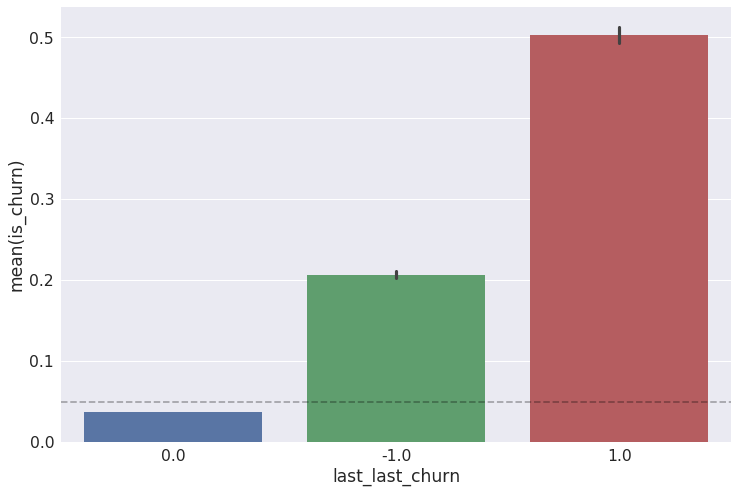

In [74]:
result_ll_churn = df_train.groupby(["last_last_churn"])['is_churn'].mean().reset_index().sort_values('is_churn')
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='last_last_churn', y='is_churn', data=df_train,ax=ax,order=result_ll_churn['last_last_churn'])
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

### Modeling

In [75]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
ll_churn_fts = age_fts + ['last_last_churn']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')


In [76]:
print('training using features: \n' ,[fts for fts in ll_churn_fts if fts not in exclude_list])
ll_churn_model_xgb, ll_churn_val_score_xgb,\
ll_churn_pred_xgb = model_training_xgb(df_train[ll_churn_fts],df_sub[ll_churn_fts])

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn']
[0]	validation_0-logloss:0.628796	validation_1-logloss:0.628753
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.154979	validation_1-logloss:0.153858
[140]	validation_0-logloss:0.1543	validation_1-logloss:0.153465
Stopping. Best iteration:
[176]	validation_0-logloss:0.154085	validation_1-logloss:0.153411



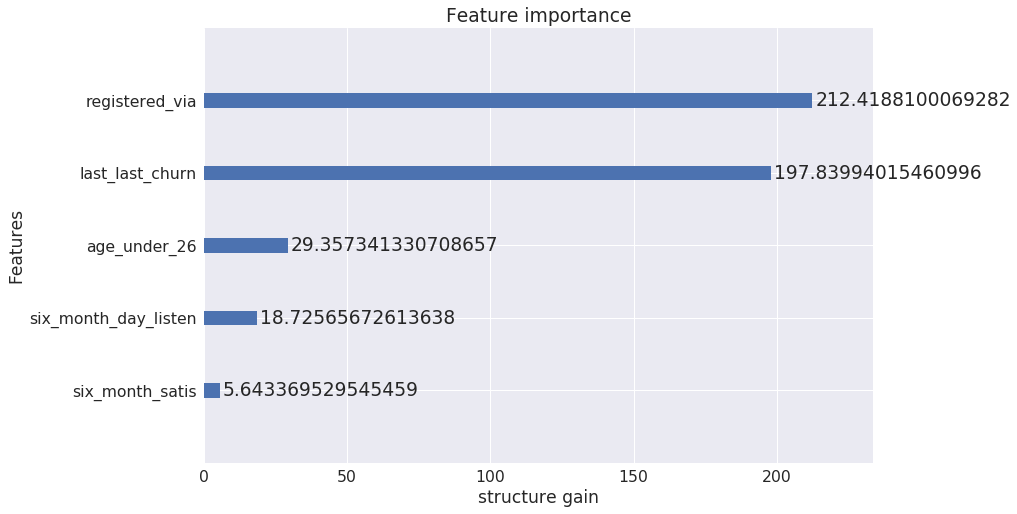

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(ll_churn_model_xgb,importance_type='gain',ax=ax,xlabel='structure gain')

In [80]:
ll_churn_pred_xgb.to_csv("/content/datalab/sub_ll_churn_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_ll_churn_xgb_pred.csv' 'gs://kk_data/submission/sub_ll_churn_xgb_pred.csv';

print('age logloss val: ',0.16151)
print('age logloss LB: ',0.13161)
print('-'*20,' + ll_churn','-'*20)
print('ll_churn log_loss LB : ',0.15347)
print('ll_churn log_loss LB : ',0.12698)

Copying file:///content/datalab/sub_ll_churn_xgb_pred.csv [Content-Type=text/csv]...
\ [1 files][ 49.1 MiB/ 49.1 MiB]                                                
Operation completed over 1 objects/49.1 MiB.                                     
age logloss val:  0.16151
age logloss LB:  0.13161
--------------------  + ll_churn --------------------
ll_churn log_loss LB :  0.15347
ll_churn log_loss LB :  0.12698


## Churn_times

In [41]:
def ft_churn_times(df):
  # to avoid mistake by chance, let's sort first
  # at the same time, groupby.cumsum has no argument about ascending, so it's necessary
  
  df = df.sort_values(by=['msno','trans_date'],ascending=True)
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)
  
  # 40 days allow more tolerance about churn
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  
  # convert boolen to 1 and 0 
  df['churn_record'] = df['churn_record']*1
  # cumsum
  df['churn_record_so_far'] = df.groupby(by=['msno'],as_index=False)['churn_record'].cumsum()

  # take out using tail instead of head
  ft = df.groupby(by=['msno'],as_index=False)[['msno','churn_record_so_far']].tail(1)
  ft = ft.rename(columns={'churn_record_so_far':'churn_times'})
  return ft

In [42]:
ft_churn_times_train = ft_churn_times(df_train_trans)
ft_churn_times_sub = ft_churn_times(df_sub_trans)

In [43]:
print(ft_churn_times_train.churn_times.value_counts())
print(ft_churn_times_sub.churn_times.value_counts())

0    687938
1    163057
2     23629
3      9127
4      2139
5       495
6       102
7        11
8         2
Name: churn_times, dtype: int64
0    707893
1    163139
2     24086
3      9337
4      2288
5       594
6       115
7        16
8         2
9         1
Name: churn_times, dtype: int64


In [44]:
df_train = pd.merge(df_train, ft_churn_times_train, how='left',on=['msno'])
df_sub = pd.merge(df_sub, ft_churn_times_sub, how='left',on=['msno'])

______________________________ All data ______________________________
____________________________________________________________
0    1395831
1     326196
2      47715
3      24229
Name: churn_times_level_code, dtype: int64
____________________________________________________________
______________________________ training_set ______________________________
0    687938
1    163057
2     23629
3     11876
Name: churn_times_level_code, dtype: int64


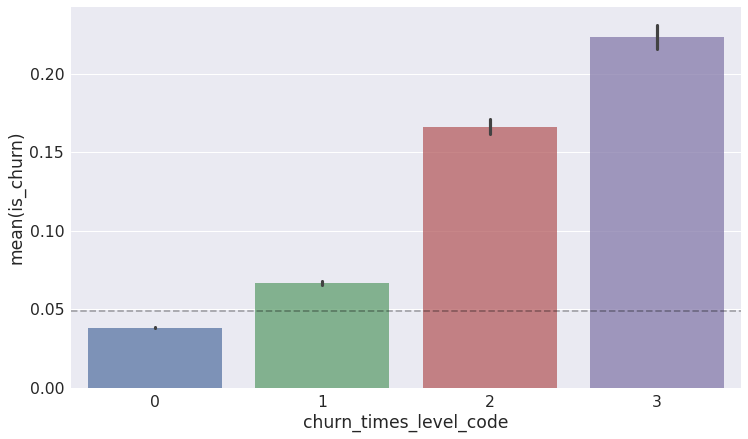

In [45]:
df_data = df_train.append(df_sub)
max_churn_times = max(df_data.churn_times)
# cut at churn_times >= 4 group named 4 up --> churn_times_level = 4

bins = [-1,0,1,2,max_churn_times]

# period = nodes - 1 --> labels = np.arange(len( bins) -1 )
df_data['churn_times_level_code'] = pd.cut(df_data.churn_times, bins, labels= np.arange( len( bins) - 1 ) )
df_data['churn_times_level_code'] = df_data['churn_times_level_code'].astype('int8')
# churn_times 1,2,3,4up
fig,ax = plt.subplots(figsize= (12,7) )
# barplot of churn rate
sns.barplot(x='churn_times_level_code', y='is_churn', data=df_data,ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed',c='black',alpha=.3)

# value_counts info
print('_'*30,'All data','_'*30)
print('_'*60)
print(df_data['churn_times_level_code'].value_counts())
print('_'*60)
print('_'*30,'training_set','_'*30)
print(df_data[:len(df_train)]['churn_times_level_code'].value_counts())

### Modeling

In [63]:
# split and prepare features 
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
churn_times_level_fts = ll_churn_fts + ['churn_times_level_code']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code'],
      dtype='object')


In [173]:
print('training using features: \n' ,[fts for fts in churn_times_level_fts if fts not in exclude_list])
churn_times_level_model_xgb, churn_times_level_val_score_xgb,\
churn_times_level_pred_xgb = model_training_xgb(df_train[churn_times_level_fts],df_sub[churn_times_level_fts])

training using features: 
 ['day_listen', 'user_latent_satisfaction', 'registered_via', 'age_under_26', 'last_last_churn', 'churn_times_level_code']
[0]	validation_0-logloss:0.628785	validation_1-logloss:0.628736
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.153608	validation_1-logloss:0.15263
[140]	validation_0-logloss:0.152802	validation_1-logloss:0.152218
[210]	validation_0-logloss:0.152382	validation_1-logloss:0.152166
Stopping. Best iteration:
[215]	validation_0-logloss:0.152359	validation_1-logloss:0.152155



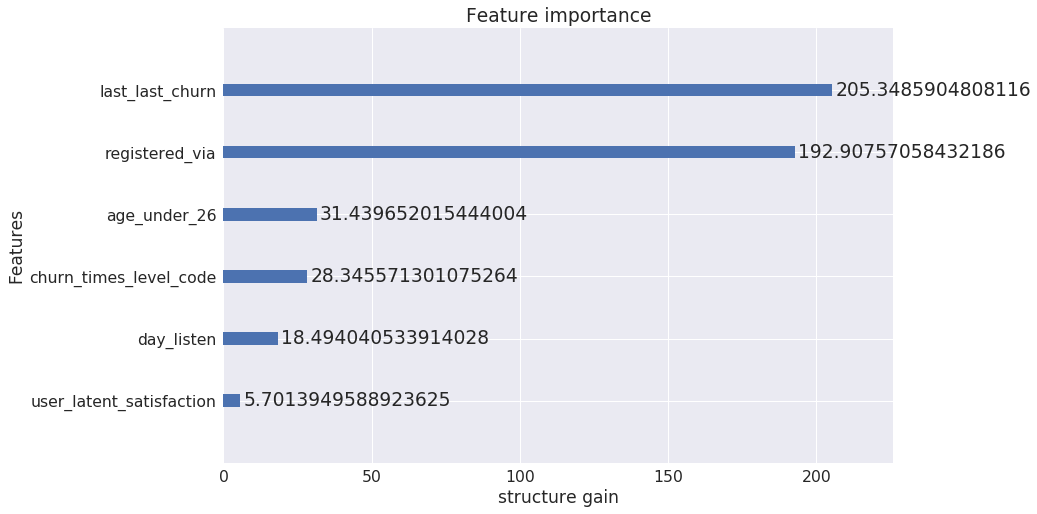

In [174]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(churn_times_level_model_xgb,importance_type='gain',ax=ax,xlabel='structure gain')

In [176]:
churn_times_level_pred_xgb.to_csv("/content/datalab/sub_churn_times_level_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_churn_times_level_xgb_pred.csv' 'gs://kk_data/submission/sub_churn_times_level_xgb_pred.csv';

print('ll_churn logloss val: ',0.15347)
print('ll_churn logloss LB: ',0.12769)
print('-'*20,' + churn_times_level','-'*20)
print('churn_times_level log_loss val : ',0.152155)
print('churn_times_level log_loss LB : ',0.12690)

Copying file:///content/datalab/sub_churn_times_level_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 49.1 MiB/ 49.1 MiB]                                                
Operation completed over 1 objects/49.1 MiB.                                     
ll_churn logloss val:  0.15347
ll_churn logloss LB:  0.12769
--------------------  + churn_times_level --------------------
churn_times_level log_loss val :  0.152155
churn_times_level log_loss LB :  0.1269


## Auto renew explore

* We cannot combine df_train_trans and df_sub_trans for exploration, due to the deplicated msno

In [47]:
# since cumsum does not support ascending = False, we resort our data with mem_expire_date first
# need to fix sort_problem
df_train_trans = df_train_trans.sort_values(by=['msno'],ascending=False).sort_values(by=['mem_expire_date'],ascending=True)
# apply function groupby.cumsum()
df_train_trans['auto_renew_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumsum()
# resort with latest expire_date first
df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False,inplace=True);
# since cumcount start at 0, we plus one for adjusting
df_train_trans['trans_times_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumcount(ascending=False) + 1

In [48]:
agg_result = df_train_trans.groupby(by=['msno'],as_index=False).head(1)
agg_result.eval('ratio_auto_renew = auto_renew_so_far / trans_times_so_far', inplace=True);

/usr/local/envs/py3env/lib/python3.5/site-packages/pandas/core/computation/eval.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  target[parsed_expr.assigner] = ret


ratio of All auto_renew:0.808
ratio of All manual_renew:0.109
ratio of Mix manual&auto renew:0.084


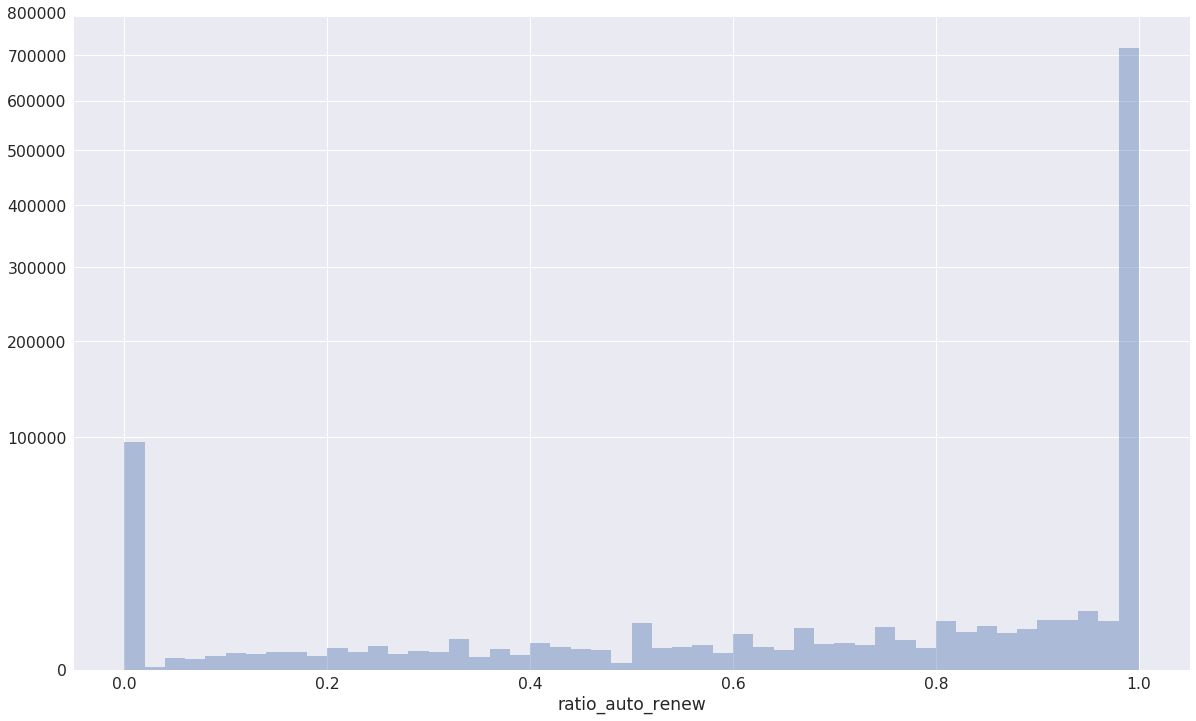

In [49]:
fig, ax = plt.subplots(figsize=(20,12))
sns.distplot(agg_result.ratio_auto_renew,kde=False,ax=ax)
ax.set_yscale('squareroot')
print('ratio of All auto_renew:%.3f'%((agg_result.ratio_auto_renew == 1 ).sum() / len(agg_result)))
print('ratio of All manual_renew:%.3f'%((agg_result.ratio_auto_renew == 0 ).sum() / len(agg_result)))
print('ratio of Mix manual&auto renew:%.3f'%(( (agg_result.ratio_auto_renew < 1) & (agg_result.ratio_auto_renew > 0) ).sum() / len(agg_result)))

In [50]:
print('All_auto_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 1').is_churn.mean()) )
print('All_manual_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 0').is_churn.mean()) )

All_auto_renew churn_rate: 0.013
All_manual_renew churn_rate: 0.287


## Last_auto_renew

In [55]:
# Feature Engineering
# for safe, sorted first
df_train_trans = df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
df_sub_trans = df_sub_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
ft_last_auto_renew_train = df_train_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
ft_last_auto_renew_sub = df_sub_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
# feature rename
ft_last_auto_renew_train.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
ft_last_auto_renew_sub.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)

In [69]:
df_train = pd.merge(df_train,ft_last_auto_renew_train,how='left',on=['msno'])
df_sub = pd.merge(df_sub,ft_last_auto_renew_sub,how='left',on=['msno'])

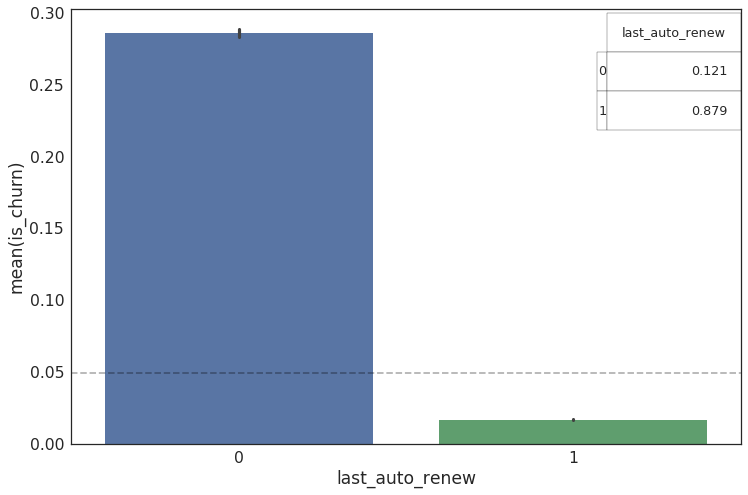

In [70]:
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize= (12,8) )
# prepare table (% of each value)
  df_percent = pd.DataFrame( df_train['last_auto_renew'].value_counts().sort_index() / len(df_train) ).round(3) 
# barplot with percent table
  sns.barplot(x='last_auto_renew',y='is_churn',data=df_train,ax=ax)
  ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### Modeling

In [101]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
last_auto_renew_fts = churn_times_level_fts + ['last_auto_renew']
exclude_list = ['msno','is_churn']
# exclude_list_2 = ['user_latent_satisfaction']
# last_auto_renew_fts = [fts for fts in last_auto_renew_fts if fts not in exclude_list_2]
last_auto_renew_fts

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew'],
      dtype='object')


['msno',
 'is_churn',
 'day_listen',
 'user_latent_satisfaction',
 'registered_via',
 'age_under_26',
 'last_last_churn',
 'churn_times_level_code',
 'last_auto_renew']

In [102]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=3,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [103]:
print('training using features: \n' ,[fts for fts in last_auto_renew_fts if fts not in exclude_list])
last_auto_renew_model_xgb, last_auto_renew_val_score_xgb,\
last_auto_renew_pred_xgb = model_training_xgb(df_train[last_auto_renew_fts],df_sub[last_auto_renew_fts])

training using features: 
 ['day_listen', 'user_latent_satisfaction', 'registered_via', 'age_under_26', 'last_last_churn', 'churn_times_level_code', 'last_auto_renew']
[0]	validation_0-logloss:0.627636	validation_1-logloss:0.627613
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.136862	validation_1-logloss:0.135925
[140]	validation_0-logloss:0.135836	validation_1-logloss:0.135235
Stopping. Best iteration:
[148]	validation_0-logloss:0.135806	validation_1-logloss:0.135229



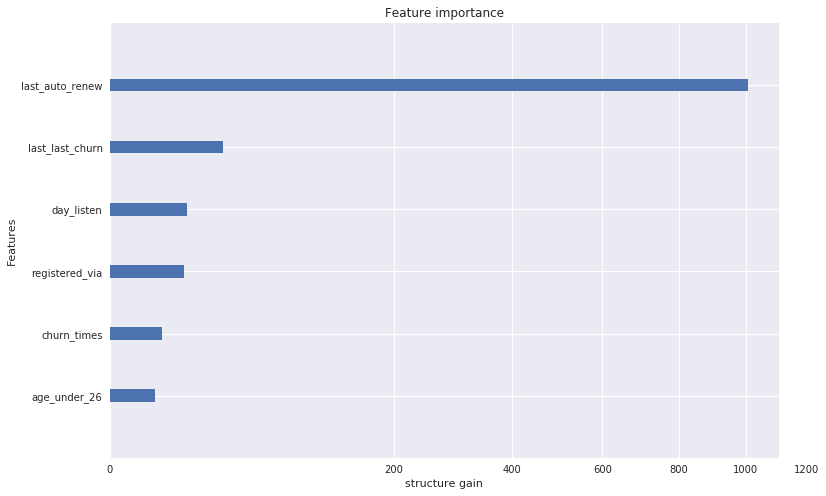

In [27]:
# show values only worked in version 0.8.0
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(last_auto_renew_model_xgb,importance_type='gain',
                    ax=ax,xlabel='structure gain',show_values=False)
ax.set_xscale('squareroot')

In [104]:
last_auto_renew_pred_xgb.to_csv("/content/datalab/sub_last_auto_renew_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_last_auto_renew_xgb_pred.csv' 'gs://kk_data/submission/sub_last_auto_renew_xgb_pred.csv';

print('churn_times_level logloss val: ',0.135215)
print('churn_times_level logloss LB: ',0.12690)
print('-'*20,' + last_auto_renew','-'*20)
print('last_auto_renew log_loss val : ',0.135229)
print('last_auto_renew log_loss LB : ',0.12188)

Copying file:///content/datalab/sub_last_auto_renew_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 49.2 MiB/ 49.2 MiB]                                                
Operation completed over 1 objects/49.2 MiB.                                     
churn_times_level logloss val:  0.135215
churn_times_level logloss LB:  0.1269
--------------------  + last_auto_renew --------------------
last_auto_renew log_loss val :  0.135229
last_auto_renew log_loss LB :  0.12188


# Change Validation Strategy

# START FROM HERE

In [131]:
df_train.to_csv("/content/datalab/df_train_tmp.csv", index=False)
!gsutil cp '/content/datalab/df_train_tmp.csv' 'gs://kk_data/df_train_tmp.csv';
df_sub.to_csv("/content/datalab/df_sub_tmp.csv", index=False)
!gsutil cp '/content/datalab/df_sub_tmp.csv' 'gs://kk_data/df_sub_tmp.csv';
df_train_trans.to_csv("/content/datalab/df_train_trans_tmp.csv", index=False)
df_sub_trans.to_csv("/content/datalab/df_sub_trans_tmp.csv", index=False)
!gsutil cp '/content/datalab/df_train_trans_tmp.csv' 'gs://kk_data/df_train_trans_tmp.csv';
!gsutil cp '/content/datalab/df_sub_trans_tmp.csv' 'gs://kk_data/df_sub_trans_tmp.csv';

Copying file:///content/datalab/df_train_tmp.csv [Content-Type=text/csv]...
\ [1 files][ 90.5 MiB/ 90.5 MiB]                                                
Operation completed over 1 objects/90.5 MiB.                                     
Copying file:///content/datalab/df_sub_tmp.csv [Content-Type=text/csv]...
\ [1 files][ 89.8 MiB/ 89.8 MiB]                                                
Operation completed over 1 objects/89.8 MiB.                                     
Copying file:///content/datalab/df_train_trans_tmp.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who do

In [1]:
!pip install -U xgboost 

  Using cached https://files.pythonhosted.org/packages/8f/15/606f81a2b8a8e82eaa10683cb3f3074905ec65d3bcef949e3f0909f165a5/xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl
  Found existing installation: xgboost 0.6a2
    Uninstalling xgboost-0.6a2:
      Successfully uninstalled xgboost-0.6a2


In [2]:
import xgboost as xgb 

In [40]:
xgb.__version__

'0.80'

In [7]:
%gcs read --object gs://kk_data/df_sub_tmp.csv -v df_sub_str

In [8]:
%gcs read --object gs://kk_data/df_train_tmp.csv -v df_train_str

In [9]:
%gcs read --object gs://kk_data/df_train_trans_tmp.csv -v df_train_trans_str

In [10]:
%gcs read --object gs://kk_data/df_sub_trans_tmp.csv -v df_sub_trans_str

In [11]:
%%time
df_train = pd.read_csv(StringIO(df_train_str))
df_sub = pd.read_csv(StringIO(df_sub_str))
df_train_trans = pd.read_csv(StringIO(df_train_trans_str))
df_sub_trans = pd.read_csv(StringIO(df_sub_trans_str))

CPU times: user 1min 5s, sys: 8.02 s, total: 1min 13s
Wall time: 1min 13s


In [12]:
df_train.shape, df_sub.shape

((886500, 14), (907471, 14))

In [13]:
df_train_trans.shape, df_sub_trans.shape

((13769249, 15), (14545180, 13))

In [14]:
# OK Let's go on 

In [15]:
from sklearn.model_selection import StratifiedKFold

In [22]:
def model_training_xgb_skf(training_data,testing_data):
  # splits train and validation set using stratifiedKFold
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2)
  # model
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=5,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1,n_jobs=-1)
  oof_train_preds = np.zeros(X.shape[0])
  sub_test_preds = np.zeros(testing_data.shape[0])
  for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    # training
    xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
    model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
    # predict on validation set
    # [:,1] to show the prob to is_churn = 1
    proba_oof = model.predict_proba(X_val)[:,1]
    oof_train_preds[val_index] = proba_oof
  
    # predict on testing set
    # take out the prob if is_churn = 1
    model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))[:,1]
    sub_test_preds += (model_pred_testing_set / skf.n_splits)
  
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=sub_test_preds)
  
  
  model_val_score = log_loss(Y,oof_train_preds)
  print('CV: ',model_val_score)
  return model, model_val_score, submission

In [23]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
last_auto_renew_fts = ['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction',
                      'registered_via','age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew']
exclude_list = ['msno','is_churn']
exclude_list_2 = ['user_latent_satisfaction']
last_auto_renew_fts = [fts for fts in last_auto_renew_fts if fts not in exclude_list_2]
last_auto_renew_fts

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew'],
      dtype='object')


['msno',
 'is_churn',
 'day_listen',
 'registered_via',
 'age_under_26',
 'last_last_churn',
 'churn_times',
 'churn_times_level_code',
 'last_auto_renew']

In [24]:
%%time
print('training using features: \n' ,[fts for fts in last_auto_renew_fts if fts not in exclude_list])
last_auto_renew_model_xgb, last_auto_renew_val_score_xgb,\
last_auto_renew_pred_xgb = model_training_xgb_skf(df_train[last_auto_renew_fts],df_sub[last_auto_renew_fts])

training using features: 
 ['day_listen', 'registered_via', 'age_under_26', 'last_last_churn', 'churn_times', 'churn_times_level_code', 'last_auto_renew']
[0]	validation_0-logloss:0.627442	validation_1-logloss:0.62744
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.135489	validation_1-logloss:0.135629
Stopping. Best iteration:
[101]	validation_0-logloss:0.135152	validation_1-logloss:0.135517

[0]	validation_0-logloss:0.627444	validation_1-logloss:0.627462
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.135355	validation_1-logloss:0.136118
[140]	validation_0-logloss:0.134807	validation_1-logloss:0.135984
Stopping. Best iteration:
[125]	validation_0-logloss:0.134874	validation_1-logloss:0.135972

[0]	va

In [25]:
last_auto_renew_pred_xgb.to_csv("/content/datalab/sub_last_auto_renew_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_last_auto_renew_xgb_pred.csv' 'gs://kk_data/submission/sub_last_auto_renew_xgb_pred.csv';

print('churn_times_level logloss val: ',0.135215)
print('churn_times_level logloss LB: ',0.12690)
print('-'*20,' + last_auto_renew','-'*20)
print('last_auto_renew log_loss CV(without user_latent_satis) : ',0.13569)
print('last_auto_renew log_loss LB : ',0.12139)

Copying file:///content/datalab/sub_last_auto_renew_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.8 MiB/ 56.8 MiB]                                                
Operation completed over 1 objects/56.8 MiB.                                     
churn_times_level logloss val:  0.135215
churn_times_level logloss LB:  0.1269
--------------------  + last_auto_renew --------------------
last_auto_renew log_loss CV(without user_latent_satis) :  0.13569
last_auto_renew log_loss LB :  X


## Switch_to_manual

In [33]:
def ft_switch_to_manual(df):
  # construct last_auto_renew
  agg_result = df.groupby(by=['msno'],as_index=False)[['msno','is_churn','is_auto_renew']].nth(0)\
  .rename(columns={'is_auto_renew':'last_auto_renew'})
  # construct last_last_auto_renew with record >= 2
  tem = df.groupby(by=['msno'],as_index=False)[['msno','is_auto_renew']].nth(1)\
  .rename(columns = {'is_auto_renew':'last_last_auto_renew'})
  # merge them
  agg_result = pd.merge(agg_result,tem,how='left',on=['msno'])

  # feature switch_to_manual
  con1 = (agg_result.last_last_auto_renew == 1.0) & (agg_result.last_auto_renew == 0)
  agg_result.loc[con1,'switch_to_manual'] = 1
  # if last_last_record = NaN, place swich_to_manual = 1 - last_record 
  # e.g. last_last = NaN , last_auto_renew = 0 ,then switch_to_manual = 1
  con2 = (agg_result.last_last_auto_renew.isnull())
  agg_result.loc[con2,'switch_to_manual'] = 1 - agg_result.loc[con2,'last_auto_renew'] 
  # others assign to 0
  agg_result.switch_to_manual.fillna(0,inplace=True)
  
  return agg_result

In [34]:
ft_switch_to_manual_train = ft_switch_to_manual(df_train_trans)
ft_switch_to_manual_sub = ft_switch_to_manual(df_sub_trans)

In [35]:
np.around(ft_switch_to_manual_train['switch_to_manual'].value_counts() / len(ft_switch_to_manual_train),decimals=4)

0.0    0.9795
1.0    0.0205
Name: switch_to_manual, dtype: float64

In [36]:
df_train = pd.merge(df_train,ft_switch_to_manual_train[['msno','switch_to_manual']]\
                    ,how='left',on=['msno'])
df_sub = pd.merge(df_sub,ft_switch_to_manual_sub[['msno','switch_to_manual']]\
                  ,how='left',on=['msno'])
# all(tem[['msno','is_auto_renew']].sort_values(by=['msno'],ascending=False).is_auto_renew.values == ft_last_auto_renew_train.is_auto_renew.values )

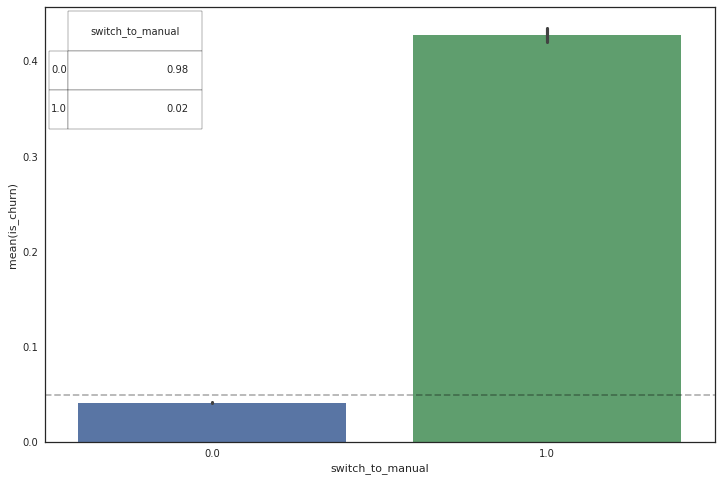

In [42]:
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize= (12,8) )
# prepare table (% of each value)
  df_percent = pd.DataFrame( df_train['switch_to_manual'].value_counts().sort_index() / len(df_train) ).round(3) 
# barplot with percent table
  sns.barplot(x='switch_to_manual',y='is_churn',data=df_train,ax=ax)
  ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

### Modeling

In [50]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
print('-'*60)
print(''*60)
uid_target = ['msno','is_churn']
exclude_list = ['user_latent_satisfaction', 'city',
       'bd', 'gender','registration_init_time', 'churn_times']

switch_to_manual_fts = [fts for fts in df_train.columns \
if fts not in exclude_list]
switch_to_manual_fts

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew', 'switch_to_manual'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew', 'switch_to_manual'],
      dtype='object')
------------------------------------------------------------



['msno',
 'is_churn',
 'day_listen',
 'registered_via',
 'age_under_26',
 'last_last_churn',
 'churn_times_level_code',
 'last_auto_renew',
 'switch_to_manual']

In [52]:
print('training using features: \n' ,[fts for fts in switch_to_manual_fts if fts not in uid_target])
switch_to_manual_model_xgb, switch_to_manual_val_score_xgb,\
switch_to_manual_pred_xgb = model_training_xgb_skf(df_train[switch_to_manual_fts],df_sub[switch_to_manual_fts])

training using features: 
 ['day_listen', 'registered_via', 'age_under_26', 'last_last_churn', 'churn_times_level_code', 'last_auto_renew', 'switch_to_manual']
[0]	validation_0-logloss:0.627442	validation_1-logloss:0.627439
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.135413	validation_1-logloss:0.135542
Stopping. Best iteration:
[93]	validation_0-logloss:0.135119	validation_1-logloss:0.135425

[0]	validation_0-logloss:0.627443	validation_1-logloss:0.627461
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.135267	validation_1-logloss:0.136136
Stopping. Best iteration:
[92]	validation_0-logloss:0.134985	validation_1-logloss:0.13603

[0]	validation_0-logloss:0.627465	validation_1-logloss:0.627465
Multi

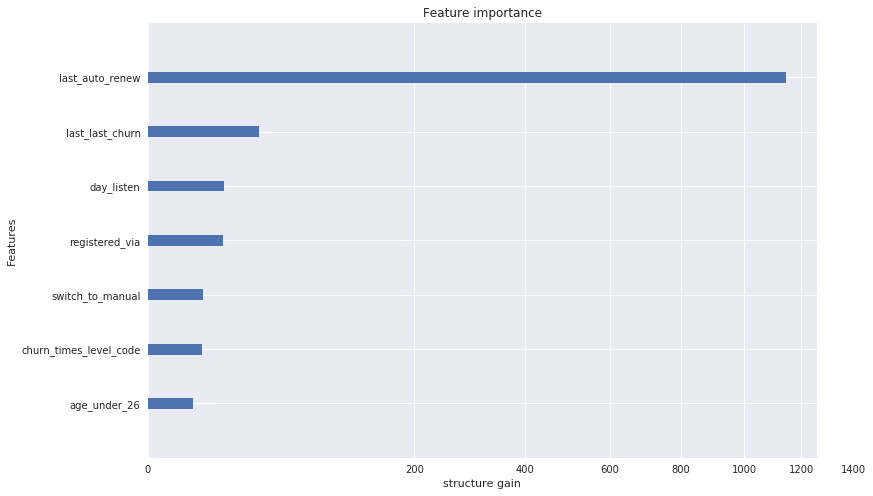

In [54]:
# show values only worked in version 0.8.0
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(switch_to_manual_model_xgb,importance_type='gain',
                    ax=ax,xlabel='structure gain',show_values=False)
ax.set_xscale('squareroot')

In [55]:
switch_to_manual_pred_xgb.to_csv("/content/datalab/sub_switch_to_manual_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_switch_to_manual_xgb_pred.csv' 'gs://kk_data/submission/sub_switch_to_manual_xgb_pred.csv';

print('last_auto_renew logloss val: ',0.13569)
print('last_auto_renew logloss LB: ',0.12139)
print('-'*20,' + switch_to_manual','-'*20)
print('switch_to_manual log_loss CV : ',0.13563)
print('switch_to_manual log_loss LB : ','X')

Copying file:///content/datalab/sub_switch_to_manual_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.7 MiB/ 56.7 MiB]                                                
Operation completed over 1 objects/56.7 MiB.                                     
churn_times_level logloss val:  0.13569
churn_times_level logloss LB:  0.12139
--------------------  + switch_to_manual --------------------
switch_to_manual log_loss CV :  0.13563
switch_to_manual log_loss LB :  X


## Trans_times

In [56]:
# Feature Engineering and merge
ft_trans_times_train = df_train_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
ft_trans_times_sub = df_sub_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
df_train = pd.merge(df_train, ft_trans_times_train, how='left', on=['msno'])
df_sub = pd.merge(df_sub, ft_trans_times_sub,how='left', on=['msno'])

In [ ]:
sns.set(font_scale=1.56)

# create fig and ax 
with sns.axes_style('white'):

    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
# distribution
    NOT_churn = ( (df_data.is_churn == 0) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    churn = ( (df_data.is_churn == 1) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    bins= 25
    sns.distplot(df_data.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_data.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# feature engineering
# create feature  bd<26 == 1, bd>26 ==0 , other = -1
    condition = df_data.bd < 26
    df_data['age_under_26'] = df_data.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_data['age_under_26'].value_counts().sort_index() / len(df_data) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_data,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

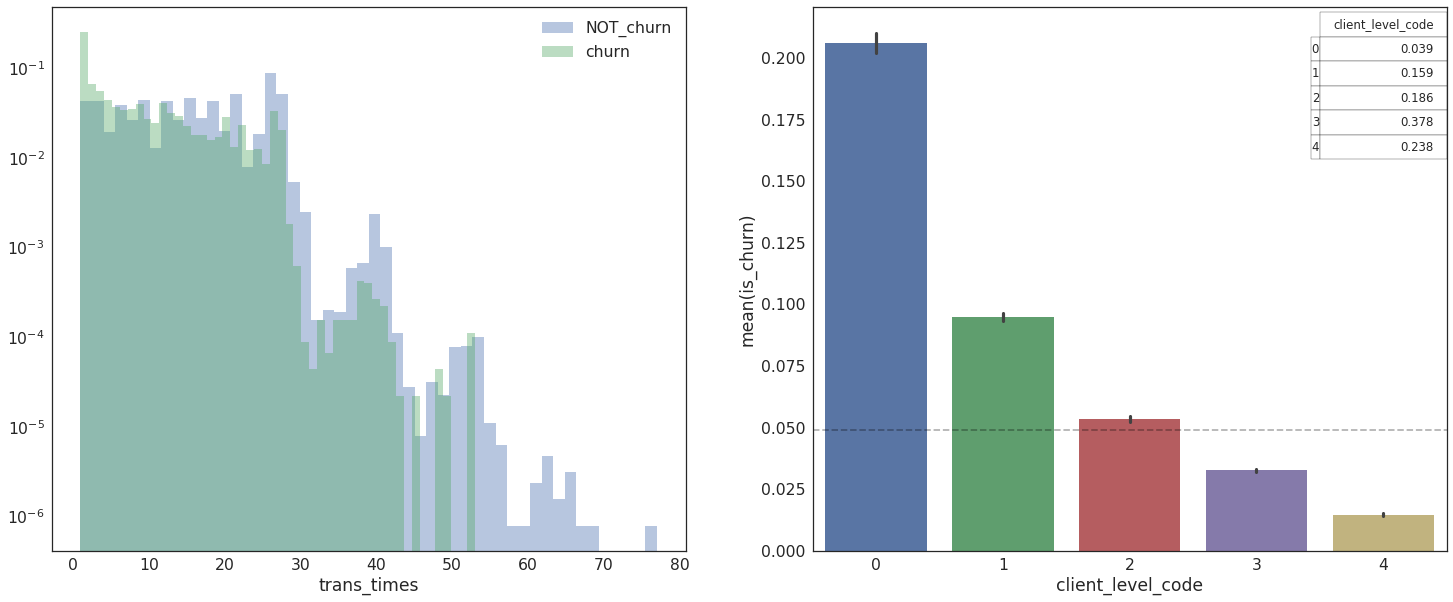

In [58]:
df_data = df_train.append(df_sub)
sns.set(font_scale=1.56)
# create fig and ax 
with sns.axes_style('white'):

  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
    
  sns.distplot(df_data.loc[(df_data.is_churn == 0), 'trans_times'],kde=False, label='NOT_churn',ax=ax1,norm_hist=True)
  sns.distplot(df_data.loc[(df_data.is_churn == 1), 'trans_times'],kde=False, label='churn',ax=ax1,norm_hist=True)
  ax1.legend()
  ax1.set_yscale('log')

  # feature enineering
  # New, Trying, OneYear, TwoYear, Stable
  max_trans = df_data.trans_times.max()
  bins = [0,1,6,12,24,max_trans]

  # period = nodes - 1 --> labels = np.arange(len( bins) -1 )
  df_data['client_level_code'] = pd.cut(df_data.trans_times, bins, labels= np.arange( len( bins) - 1 ) )
  df_data['client_level_code'] = df_data['client_level_code'].astype('int8')

  # prepare table (% of each value)
  df_percent = pd.DataFrame( df_data['client_level_code'].value_counts().sort_index() / len(df_data) ).round(3) 
  # barplot of churn rate
  sns.barplot(x='client_level_code',y='is_churn',data=df_data,ax=ax2)
  ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

## Modeling

In [60]:
# split and prepare features 
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
print('-'*60)
print(''*60)
uid_target = ['msno','is_churn']
exclude_list = ['user_latent_satisfaction', 'city',
       'bd', 'gender','registration_init_time', 'churn_times','trans_times']

client_level_code_fts = [fts for fts in df_train.columns \
if fts not in exclude_list]
client_level_code_fts

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew', 'switch_to_manual',
       'trans_times', 'client_level_code'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'churn_times',
       'churn_times_level_code', 'last_auto_renew', 'switch_to_manual',
       'trans_times', 'client_level_code'],
      dtype='object')
------------------------------------------------------------



['msno',
 'is_churn',
 'day_listen',
 'registered_via',
 'age_under_26',
 'last_last_churn',
 'churn_times_level_code',
 'last_auto_renew',
 'switch_to_manual',
 'client_level_code']

In [64]:
def model_training_xgb_skf(training_data,testing_data):
  # splits train and validation set using stratifiedKFold
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2)
  # model
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=5,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1,n_jobs=-1)
  oof_train_preds = np.zeros(X.shape[0])
  sub_test_preds = np.zeros(testing_data.shape[0])
  for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    # training
    xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
    model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
    # predict on validation set
    # [:,1] to show the prob to is_churn = 1
    proba_oof = model.predict_proba(X_val)[:,1]
    oof_train_preds[val_index] = proba_oof
  
    # predict on testing set
    # take out the prob if is_churn = 1
    model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))[:,1]
    sub_test_preds += (model_pred_testing_set / skf.n_splits)
  
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=sub_test_preds)
  
  
  model_val_score = log_loss(Y,oof_train_preds)
  print('CV: ',model_val_score)
  return model, model_val_score, submission

In [65]:
print('training using features: \n' ,[fts for fts in client_level_code_fts if fts not in uid_target])
client_level_code_model_xgb, client_level_code_val_score_xgb,\
client_level_code_pred_xgb = model_training_xgb_skf(df_train[client_level_code_fts],df_sub[client_level_code_fts])

training using features: 
 ['day_listen', 'registered_via', 'age_under_26', 'last_last_churn', 'churn_times_level_code', 'last_auto_renew', 'switch_to_manual', 'client_level_code']
[0]	validation_0-logloss:0.659597	validation_1-logloss:0.659599
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.146969	validation_1-logloss:0.147133
[140]	validation_0-logloss:0.13418	validation_1-logloss:0.134693
Stopping. Best iteration:
[176]	validation_0-logloss:0.1338	validation_1-logloss:0.134522

[0]	validation_0-logloss:0.659595	validation_1-logloss:0.659605
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.146817	validation_1-logloss:0.147555
[140]	validation_0-logloss:0.13401	validation_1-logloss:0.135313
[210]	vali

In [62]:
client_level_code_pred_xgb.to_csv("/content/datalab/sub_client_level_code_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_client_level_code_xgb_pred.csv' 'gs://kk_data/submission/sub_client_level_code_xgb_pred.csv';

print('switch_to_manual logloss val: ',0.13563)
print('switch_to_manual logloss LB: ',0.12133)
print('-'*20,' + client_level_code','-'*20)
print('client_level_code log_loss CV : ',0.13480)
print('client_level_code log_loss LB : ','X')

Copying file:///content/datalab/sub_client_level_code_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.8 MiB/ 56.8 MiB]                                                
Operation completed over 1 objects/56.8 MiB.                                     
switch_to_manual logloss val:  0.13563
switch_to_manual logloss LB:  0.12133
--------------------  + client_level_code --------------------
client_level_code log_loss CV :  0.1348
client_level_code log_loss LB :  X
